In [9]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
import pandas as pd
from sklearn.metrics import mean_squared_error
import numpy as np
from sentence_transformers import SentenceTransformer

In [19]:

train_df = pd.read_csv("train.csv")
val_df = pd.read_csv("val.csv")
test_df = pd.read_csv("test.csv")

device = torch.device("cpu")

In [11]:
model_st = SentenceTransformer("all-MiniLM-L6-v2")
X_train = model_st.encode(train_df["query"].tolist(), convert_to_tensor=True)
X_val = model_st.encode(val_df["query"].tolist(), convert_to_tensor=True)

y_train = torch.tensor(train_df["carb"].values, dtype=torch.float32).unsqueeze(1)
y_val = torch.tensor(val_df["carb"].values, dtype=torch.float32).unsqueeze(1)
X_train = X_train.unsqueeze(1)  # (N, 1, 384)
X_val = X_val.unsqueeze(1)

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

X_train.shape

torch.Size([8000, 1, 384])

In [12]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=384, hidden_size=128, num_layers=2, dropout=0.4):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers,
                            dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)          # x: (batch, seq_len, input_size)
        out = out[:, -1, :]            # Get last time step
        return self.fc(out)


Validation RMSE: 37.62
Epoch 1, Train Loss: 476839.2807, Train RMSE: 43.67
Validation RMSE: 35.91
Epoch 2, Train Loss: 409978.1778, Train RMSE: 40.50
Validation RMSE: 34.99
Epoch 3, Train Loss: 385961.6423, Train RMSE: 39.29
Validation RMSE: 34.40
Epoch 4, Train Loss: 370338.2982, Train RMSE: 38.49
Validation RMSE: 33.92
Epoch 5, Train Loss: 357779.4920, Train RMSE: 37.83
Validation RMSE: 33.30
Epoch 6, Train Loss: 346304.9799, Train RMSE: 37.22
Validation RMSE: 33.31
Epoch 7, Train Loss: 337276.9997, Train RMSE: 36.73
Validation RMSE: 32.65
Epoch 8, Train Loss: 327354.3362, Train RMSE: 36.19
Validation RMSE: 32.06
Epoch 9, Train Loss: 318929.0929, Train RMSE: 35.72
Validation RMSE: 32.11
Epoch 10, Train Loss: 309511.6138, Train RMSE: 35.19
Validation RMSE: 31.61
Epoch 11, Train Loss: 302299.0176, Train RMSE: 34.77
Validation RMSE: 31.74
Epoch 12, Train Loss: 292881.2049, Train RMSE: 34.23
Validation RMSE: 31.78
Epoch 13, Train Loss: 286985.5447, Train RMSE: 33.88
Validation RMSE: 30.2

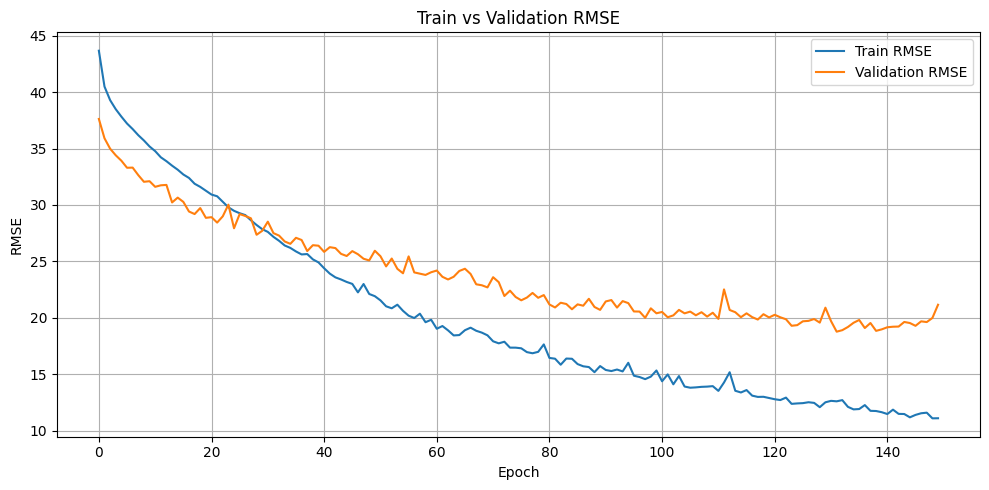

In [14]:
import math
import torch.nn.functional as F

model = LSTMModel()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
criterion = nn.MSELoss()

train_rmse_history = []
val_rmse_history = []

for epoch in range(150):
    model.train()
    train_preds = []
    train_targets = []
    total_loss = 0

    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        train_preds.append(pred.detach())
        train_targets.append(yb)

    train_preds = torch.cat(train_preds)
    train_targets = torch.cat(train_targets)
    train_rmse = math.sqrt(F.mse_loss(train_preds, train_targets).item())

    train_rmse_history.append(train_rmse)

    model.eval()
    with torch.no_grad():
        preds = []
        targets = []
        for xb, yb in val_loader:
            y_pred = model(xb)
            preds.append(y_pred)
            targets.append(yb)
    
        preds = torch.cat(preds)
        targets = torch.cat(targets)
        rmse = math.sqrt(F.mse_loss(preds, targets).item())
        val_rmse_history.append(rmse)
        print(f"Validation RMSE: {rmse:.2f}")


    print(f"Epoch {epoch+1}, Train Loss: {total_loss:.4f}, Train RMSE: {train_rmse:.2f}")

plt.figure(figsize=(10, 5))
plt.plot(train_rmse_history, label='Train RMSE')
plt.plot(val_rmse_history, label='Validation RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('Train vs Validation RMSE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("rmse_LSTM.png")  # or plt.show() to display in notebook

In [41]:
import seaborn as sns

class SentenceEmbeddingInterpreter:
    def __init__(self, model):
        self.model = model

    def forward(self, x):
        x.requires_grad = True
        self.input_tensor = x
        output = self.model(x)
        return output

    def zero_grad(self):
        self.model.zero_grad()
        if self.input_tensor.grad is not None:
            self.input_tensor.grad.zero_()

    def get_token_importance(self):
        grads = self.input_tensor.grad.detach().cpu().squeeze()      # [384]
        inputs = self.input_tensor.detach().cpu().squeeze()          # [384]
        importance = (grads * inputs).tolist()                       # Element-wise grad × input
        return importance

def visualize_sentence_embedding_importance(tokens, importances, filename=None):

    min_len = min(len(tokens), len(importances))
    tokens = tokens[:min_len]
    importances = importances[:min_len]

    fig, ax = plt.subplots(figsize=(15, 2.5))
    sns.heatmap([importances], annot=[tokens], cmap="Reds", fmt="", cbar=True, ax=ax)
    ax.set_title("Token Importance")
    plt.tight_layout()

    if filename:
        plt.savefig(filename)

    plt.show()  # ✅ This will display it in the notebook
    plt.close()

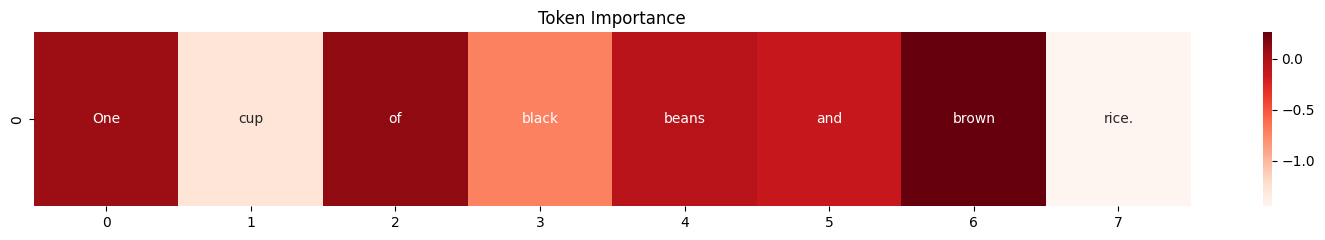

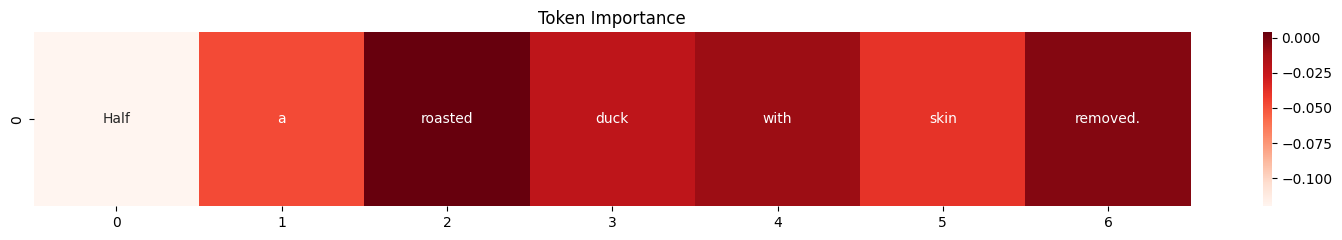

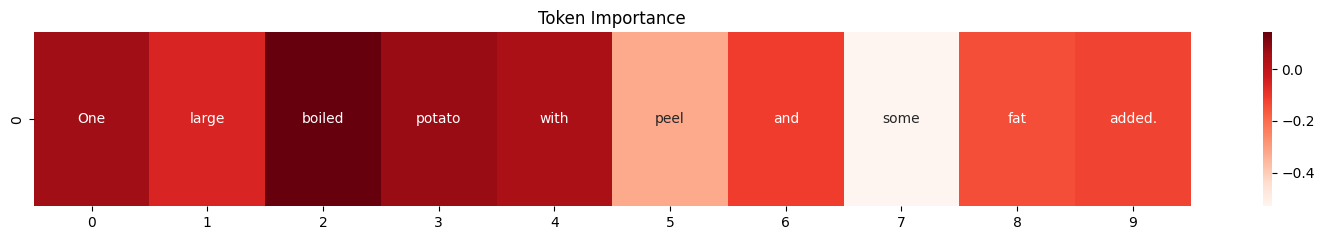

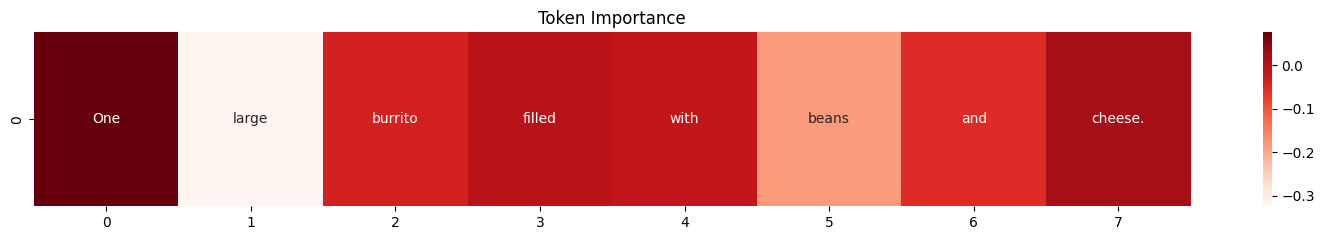

In [42]:
for i in range (0,4):

    sentence = val_df["query"].iloc[3*i]
    tokens = sentence.split()  # adjust if using tokenizer instead
    
    sample_x = X_val[i].unsqueeze(0).requires_grad_().to(device)
    
    interpreter = SentenceEmbeddingInterpreter(model)
    output = interpreter.forward(sample_x)
    interpreter.zero_grad()
    output.backward()
    
    importances = interpreter.get_token_importance()
    visualize_sentence_embedding_importance(tokens, importances, filename = "Token Importance of index" + str(3*i))


In [33]:
print("x")

x
